Украинский Александр Сергеевич 3825М1ПМкн1

Набор данных включает в себя медицинские и демографических данные
для прогнозирования наличия или отсутствия у пациента диабета.
Мы будем разрабатывать прогностическую модель, которая на основе
анамнеза пациента и текущих клинических показателей сможет оценить
вероятность наличия диабета.

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from imblearn.over_sampling import SMOTE

In [249]:
path="diabetes_prediction_dataset.csv"
datafile = pd.read_csv(path)

print(datafile.shape)

(100000, 9)


Набор данных содержит 100000 записей и 9 признаков. Выведем информацию из датасета.

In [250]:
pd.set_option('display.max_columns', None)

print(datafile.head())
print(datafile.tail())

print(datafile.columns)

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
       gender   age  hypertension  heart_disease smoking_history    bmi  \
99995  Female  80.0             0              0         No Info  27.32   
99996  Female   2.0             0              0         No Info  17.37   
99997    Male  66.0             0              0          fo

Мы вывели список первых пяти и последних пяти строк. Каждая из них описывает пациента.
Каждый пациент характеризуется следующим набором признаков:
* gender - пол пациента
* age - возраст пациента
* hypertension - наличие или отсутствие у пациента артериальной гипертензии
* heart_disease - наличие или отсутствие сердечных заболеваний
* smoking_history - история курения пациента
* bmi - индекс массы тела
* HbA1c_level - уровень гликированного гемоглобина(средний уровень глюкозы в крови за 2-3 месяца)
* blood_glucose_level - уровень глюкозы в крови
* diabetes - наличие или отсутствие диабета у пациента

Признак diabetes является целевым. Наша задача научится предсказывать значение признака diabetes по остальным признакам.

Выведем детализированную информацию о данных:

In [251]:
datafile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


Имеем 9 различных признаков, 100000 записей, без явных пропусков.

Признаки hypertension, heart_disease, diabetes, smoking_history и gender категориальные,
остальные признаки числовые.

Заменим тип категориальнных признаков

In [252]:
datafile['gender'] = datafile['gender'].astype('category')
datafile['smoking_history'] = datafile['smoking_history'].astype('category')

Исследуем категориальные признаки:

In [253]:
print(datafile.describe(include=['category']))

        gender smoking_history
count   100000          100000
unique       3               6
top     Female         No Info
freq     58552           35816


Можно заметить наличие 3-х уникальных значений признака gender. Проведем
базовую очистку данных для обеспечения качества анализа.

In [254]:
datafile = datafile.drop(datafile[datafile['gender'] == 'Other'].index)
datafile['gender'] = datafile['gender'].astype('category')
datafile['smoking_history'] = datafile['smoking_history'].astype('category')

print(datafile.describe(include=['category']))

        gender smoking_history
count    99982           99982
unique       2               6
top     Female         No Info
freq     58552           35810


Было удалено 18 записей

Приведем статистику по категориальным признакам:

In [255]:
print(datafile['gender'].value_counts())
print(datafile['smoking_history'].value_counts())

gender
Female    58552
Male      41430
Other         0
Name: count, dtype: int64
smoking_history
No Info        35810
never          35092
former          9352
current         9286
not current     6439
ever            4003
Name: count, dtype: int64


Статистика по числовым признакам:

In [256]:
print(datafile.describe())
key_insights = {
    "Средний возраст": f"{datafile.describe().loc['mean', 'age']:.1f} лет",
    "Распространенность гипертонии": f"{datafile.describe().loc['mean', 'hypertension']*100:.1f}%",
    "Распространенность болезней сердца": f"{datafile.describe().loc['mean', 'heart_disease']*100:.1f}%",
    "Средний ИМТ": f"{datafile.describe().loc['mean', 'bmi']:.1f}",
    "Средний уровень HbA1c": f"{datafile.describe().loc['mean', 'HbA1c_level']:.1f}",
    "Средний уровень глюкозы": f"{datafile.describe().loc['mean', 'blood_glucose_level']:.1f}",
    "Распространенность диабета": f"{datafile.describe().loc['mean', 'diabetes']*100:.1f}%"
}

print('\n')
for insight, value in key_insights.items():
    print(f"• {insight}: {value}")

print(f"\nРазброс данных (стандартное отклонение):")
print(f"• Возраст: ±{datafile.describe().loc['std', 'age']:.1f} лет")
print(f"• ИМТ: ±{datafile.describe().loc['std', 'bmi']:.1f}")
print(f"• Уровень глюкозы: ±{datafile.describe().loc['std', 'blood_glucose_level']:.1f}")

                age  hypertension  heart_disease           bmi   HbA1c_level  \
count  99982.000000  99982.000000   99982.000000  99982.000000  99982.000000   
mean      41.888076      0.074863       0.039427     27.320757      5.527529   
std       22.517206      0.263172       0.194610      6.636853      1.070665   
min        0.080000      0.000000       0.000000     10.010000      3.500000   
25%       24.000000      0.000000       0.000000     23.630000      4.800000   
50%       43.000000      0.000000       0.000000     27.320000      5.800000   
75%       60.000000      0.000000       0.000000     29.580000      6.200000   
max       80.000000      1.000000       1.000000     95.690000      9.000000   

       blood_glucose_level      diabetes  
count         99982.000000  99982.000000  
mean            138.057810      0.085015  
std              40.709469      0.278906  
min              80.000000      0.000000  
25%             100.000000      0.000000  
50%             140.0

Проведем анализ зависимости между признаками:

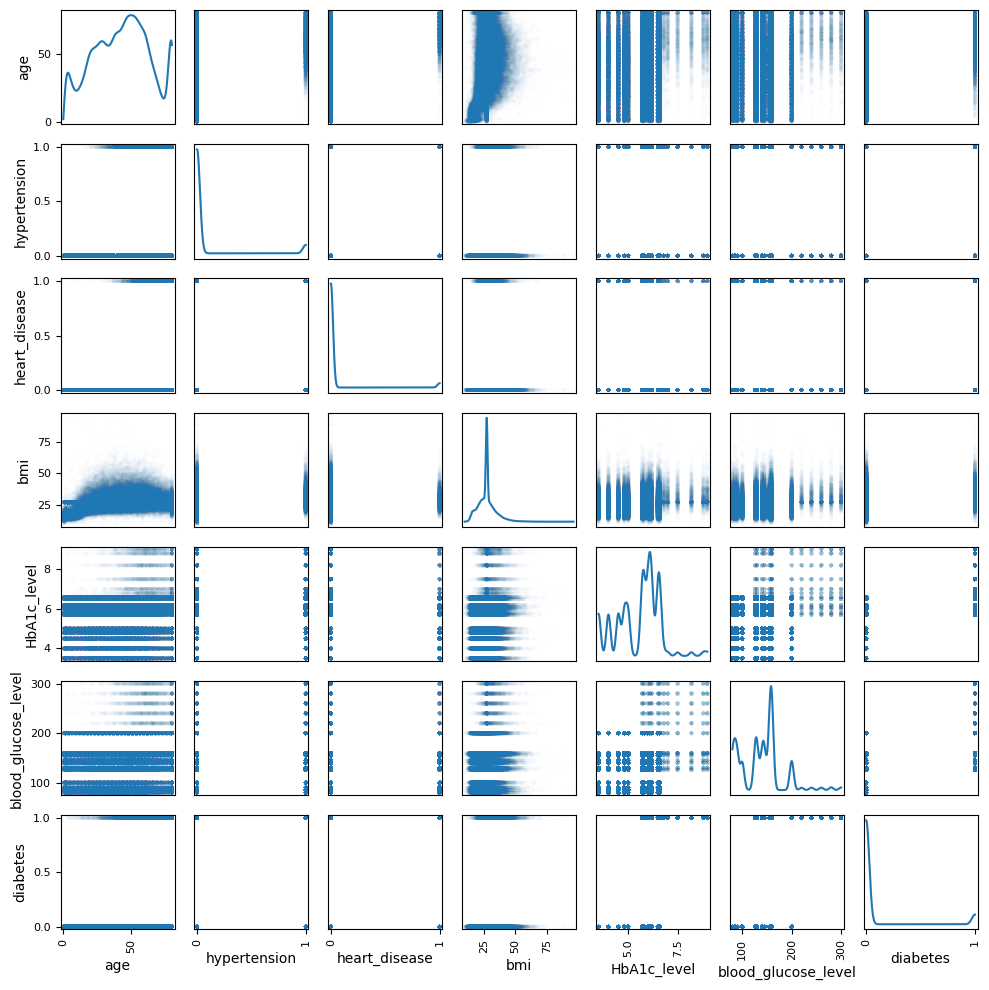

In [257]:
from pandas.plotting import scatter_matrix

scatter_matrix(datafile, alpha=.01, figsize=(10, 10), diagonal='kde')
plt.tight_layout()
plt.show()

Построим матрицу корреляции между числовыми признаками:

                          age  hypertension  heart_disease       bmi  \
age                  1.000000      0.251163       0.233352  0.337378   
hypertension         0.251163      1.000000       0.121253  0.147679   
heart_disease        0.233352      0.121253       1.000000  0.061203   
bmi                  0.337378      0.147679       0.061203  1.000000   
HbA1c_level          0.101343      0.080941       0.067591  0.083017   
blood_glucose_level  0.110679      0.084436       0.070071  0.091310   
diabetes             0.257999      0.197811       0.171718  0.214377   

                     HbA1c_level  blood_glucose_level  diabetes  
age                     0.101343             0.110679  0.257999  
hypertension            0.080941             0.084436  0.197811  
heart_disease           0.067591             0.070071  0.171718  
bmi                     0.083017             0.091310  0.214377  
HbA1c_level             1.000000             0.166831  0.400696  
blood_glucose_level     0.1

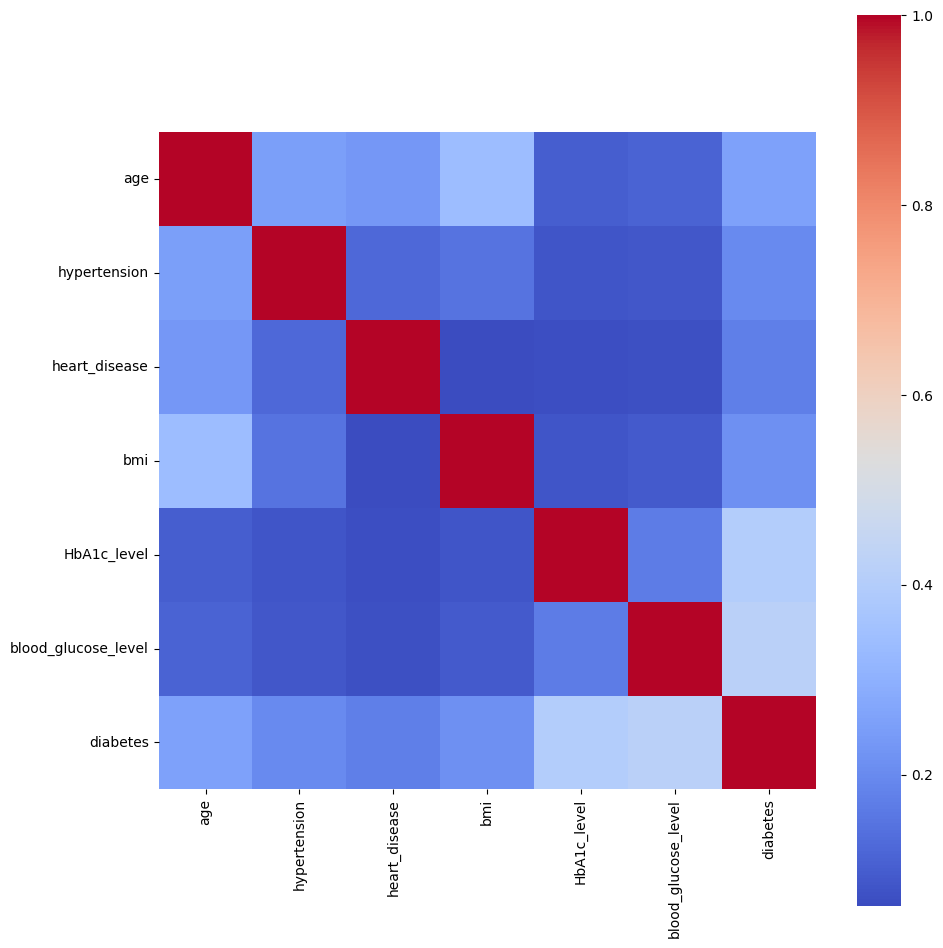

In [258]:
corr_matrix = datafile.corr(numeric_only=True)
print(corr_matrix)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix, square=True, cmap='coolwarm')
plt.tight_layout()
plt.show()

Заметим небольшую зависимость между возрастом и ИМТ, а также между целевой переменной и
переменными HbA1c_level и blood_glucose_level

Исследуем распределение признаков:

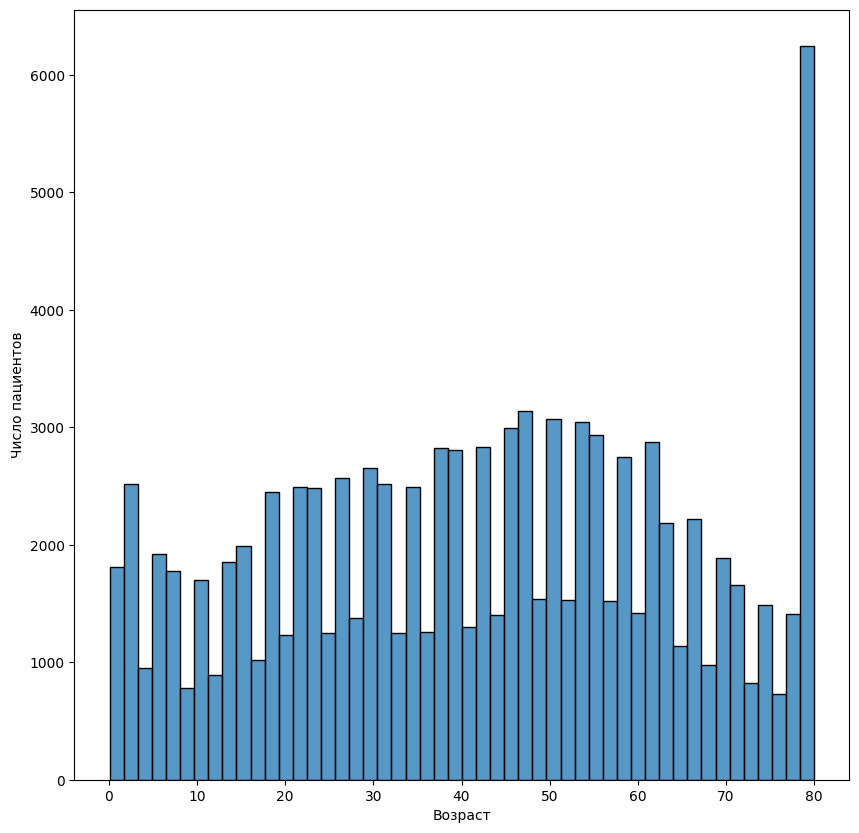

In [259]:
plt.figure(figsize=(10, 10))
sns.histplot(datafile['age'], bins = 50, kde_kws={'color': 'skyblue'})
plt.xlabel('Возраст')
plt.ylabel('Число пациентов')
plt.show()

Распределение возраста пациентов относительно равномерно.

Исключение составляют пациенты возраста 80 лет, их количество сильно
превалирует. Однако это соответствует реальности, вследствие чего может добавить модели информативности.

Исследуем зависимость между полом пациента и наличием у него диабета:

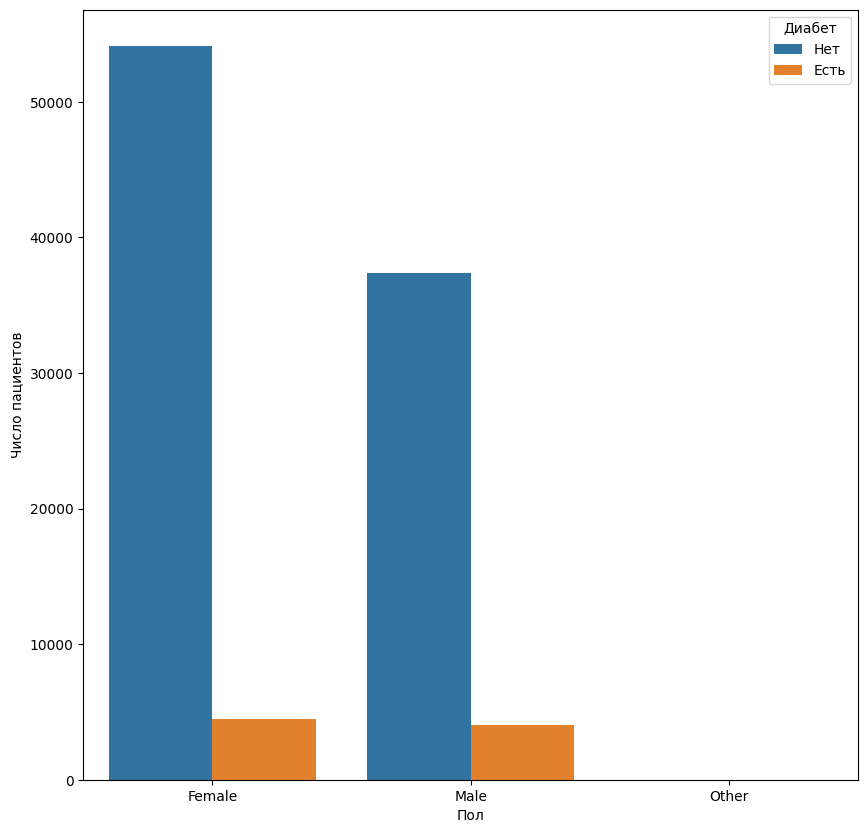

In [260]:
plt.figure(figsize=(10, 10))
sns.countplot(data = datafile, x = 'gender', hue = 'diabetes')
plt.xlabel('Пол')
plt.ylabel('Число пациентов')
plt.legend(title = 'Диабет', labels = ['Нет', 'Есть'])
plt.show()

Статистика распространения диабета по полу:

In [261]:
gender_diabetes = datafile.groupby('gender', observed=False)['diabetes'].mean() * 100
print(f"Распространенность диабета по полу:")
for gender, rate in gender_diabetes.items():
    print(f"• {gender}: {rate:.2f}%")

Распространенность диабета по полу:
• Female: 7.62%
• Male: 9.75%
• Other: nan%


Исследуем распространение категориальных переменных:

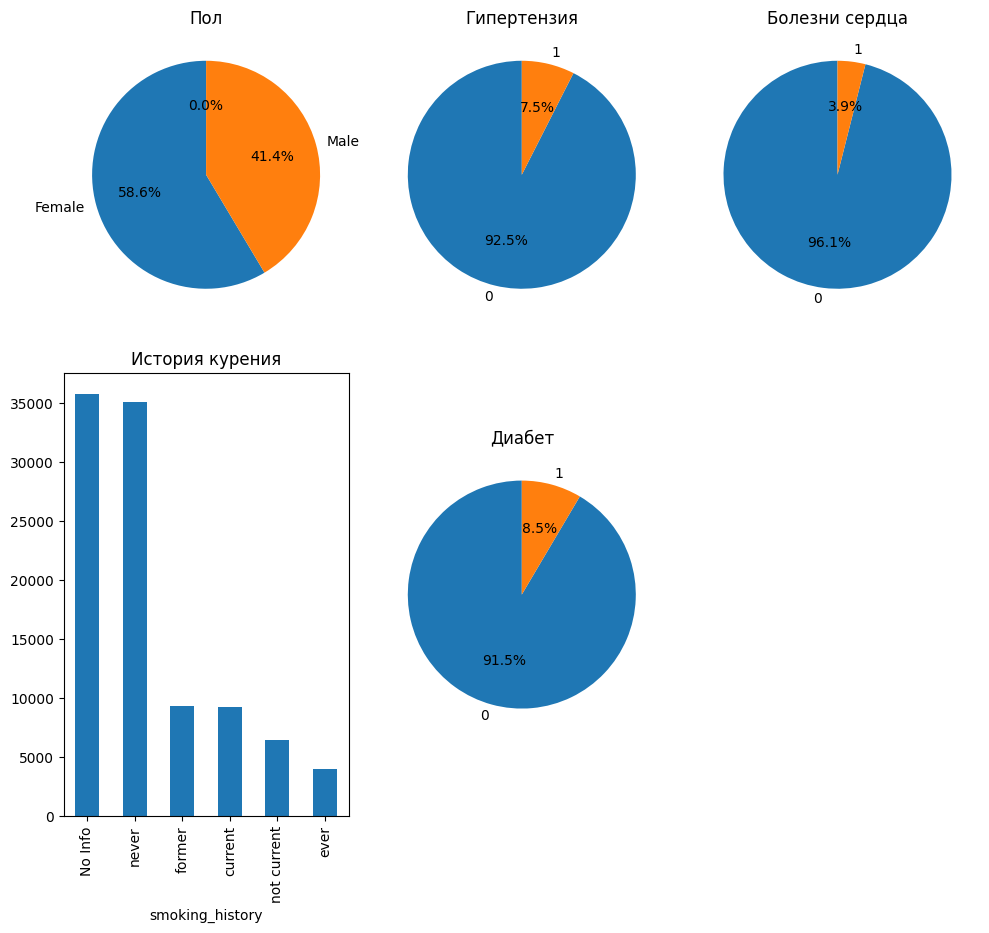

In [262]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))
axes = axes.ravel()

vars = ['gender', 'hypertension', 'heart_disease', 'smoking_history', 'diabetes']
titles = ['Пол', 'Гипертензия', 'Болезни сердца', 'История курения', 'Диабет']

for i, (var, title) in enumerate(zip(vars, titles)):
    counts = datafile[var].value_counts()
    if var == 'smoking_history':
        counts.plot(kind='bar', stacked=True, ax=axes[i])
        axes[i].set_title(title)
    else:
        counts.plot(kind='pie', autopct='%1.1f%%', stacked=True, ax=axes[i], startangle=90)
        axes[i].set_ylabel('')
        axes[i].set_title(title)
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

Есть небольшой дисбаланс в распределении по половому признаку

Дисбаланс по другим признакам объясняется естественными причинами

Обработка выбросов:

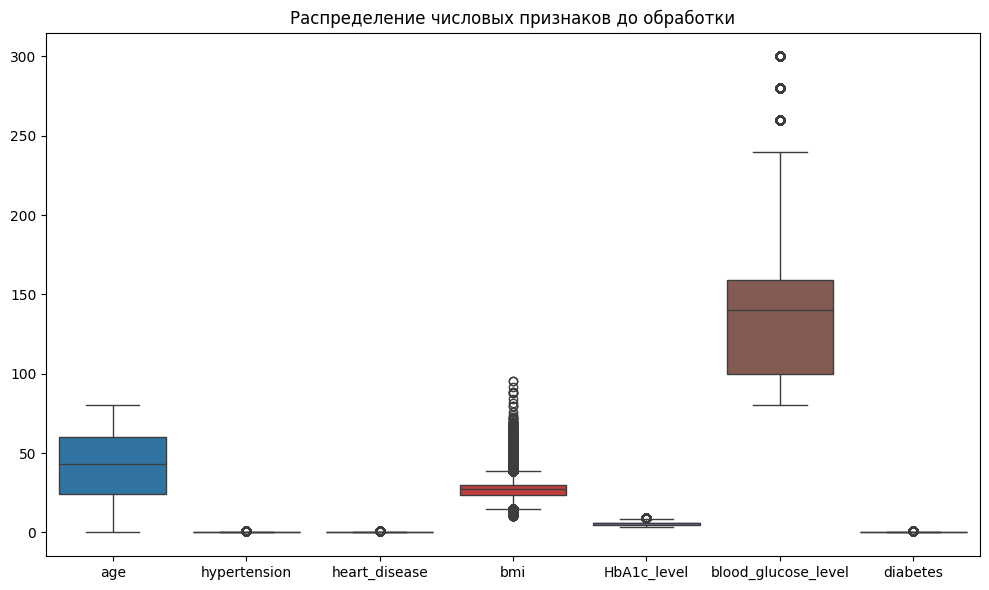

In [263]:
plt.figure(figsize=(10, 6))
sns.boxplot(data = datafile.select_dtypes(include=[np.number]))
plt.title('Распределение числовых признаков до обработки')
plt.tight_layout()
plt.show()

Можно заметить выбросы в bmi и blood_glucose_level.

Удалим соответствующие записи:

(96366, 9)


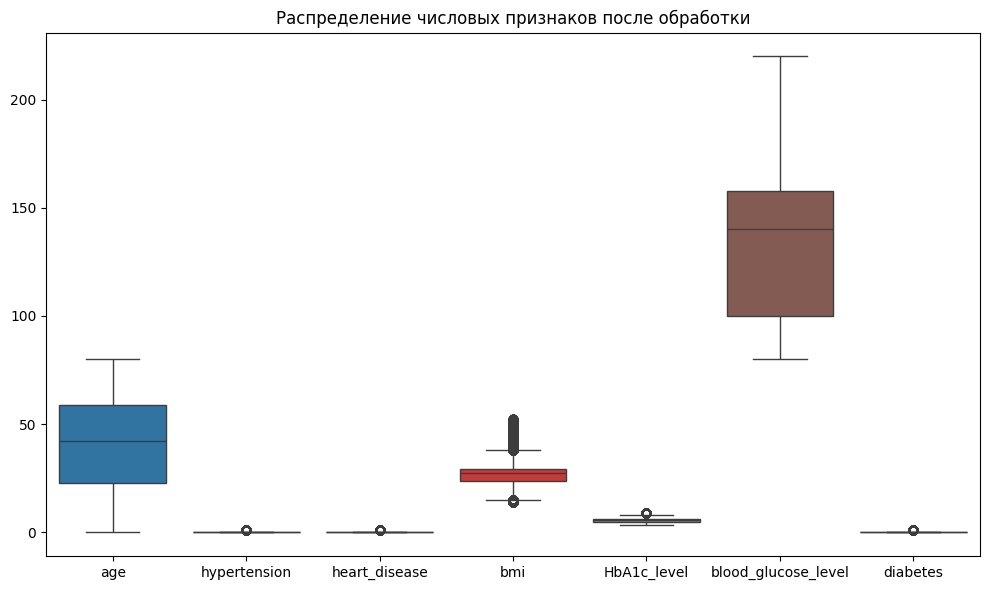

In [264]:
bmi_lower = datafile['bmi'].quantile(0.005)
bmi_upper = datafile['bmi'].quantile(0.995)

glucose_upper = datafile['blood_glucose_level'].quantile(0.97)

rows_to_drop = datafile[(datafile['bmi'] < bmi_lower)
                        | (datafile['bmi'] > bmi_upper) | (datafile['blood_glucose_level'] > glucose_upper)].index
datafile.drop(rows_to_drop, inplace=True)

print(datafile.shape)

plt.figure(figsize=(10, 6))
sns.boxplot(data = datafile.select_dtypes(include=[np.number]))
plt.title('Распределение числовых признаков после обработки')
plt.tight_layout()
plt.show()

Проведем обработку пропущенных значений:

In [265]:
print(datafile.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


Явные пропуски отсутствуют, однако, мы уже замечали неявные пропуски
в поле gender. Пропуски в поле gender были малочисленны, их мы уже удалили. Однако при рассмотрении уникальных значений поля 'smoking_history' было обнаружено значение 'No Info'.
Обработаем пропуски в smoking_history:

In [266]:
print((datafile['smoking_history'] == 'No Info').sum())

34806


Всего насчитывается 34806 записи с отсутствующей информацией о курении пациента.
Данное значение очень велико, поэтому просто исключить данные поля нельзя.
Проведем сравнительный анализ группы 'No Info' и остальных групп.

In [267]:
no_info = datafile['smoking_history'] == 'No Info'
no_info_subset = datafile[no_info]
other_subset = datafile[~no_info]


no_info_stats = no_info_subset.describe().loc[['mean', 'std']]
other_stats = other_subset.describe().loc[['mean', 'std']]

comparison_stats = pd.concat({
    'No Info группа': no_info_stats,
    'Остальные пациенты': other_stats
}, axis=1)

display(comparison_stats)

No Info группа                                                    \
                age hypertension heart_disease        bmi HbA1c_level   
mean      33.493879     0.031661      0.024536  25.318428    5.440953   
std       24.796149     0.175099      0.154708   5.964374    1.005127   

                                   Остальные пациенты               \
     blood_glucose_level  diabetes                age hypertension   
mean          133.377636  0.027323          46.065135     0.091927   
std            34.435447  0.163025          19.512015     0.288925   

                                                                         
     heart_disease        bmi HbA1c_level blood_glucose_level  diabetes  
mean      0.043600  28.141878    5.515361          134.977648  0.077404  
std       0.204205   6.026235    1.065098           34.567932  0.267234

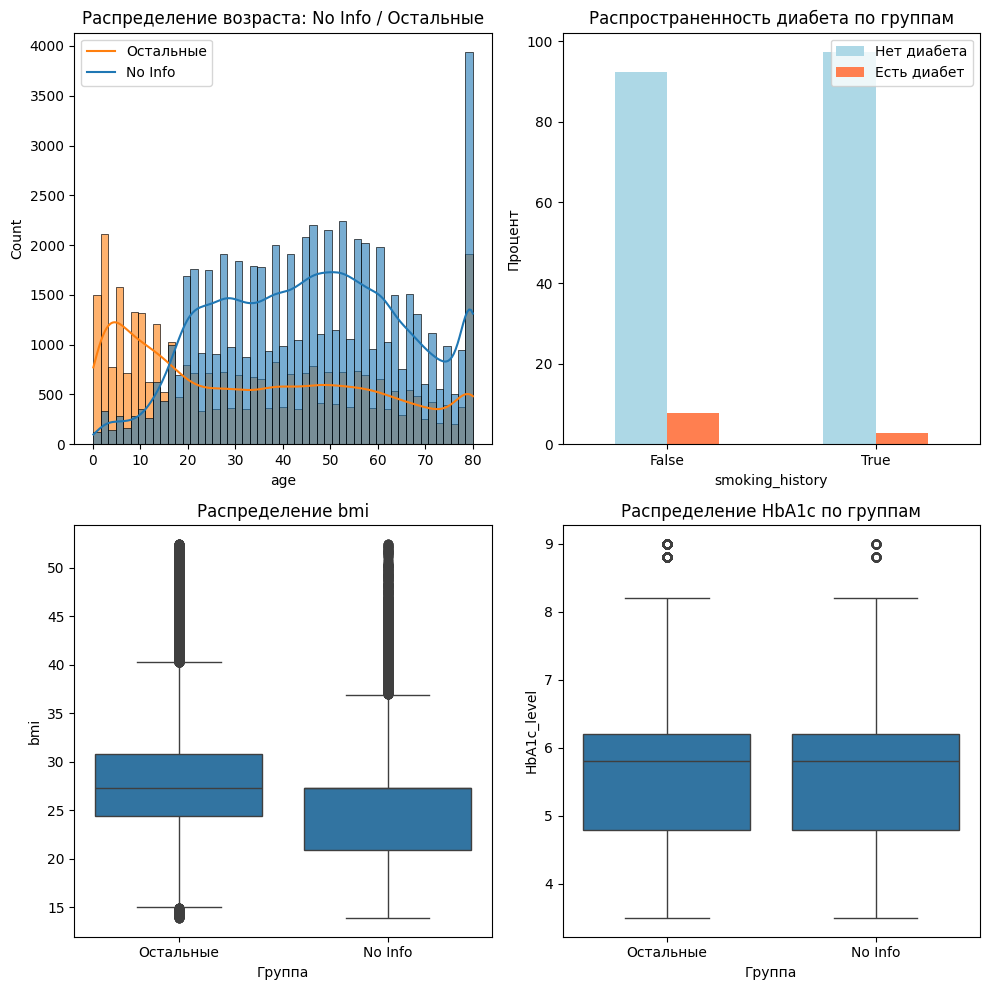

In [268]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=datafile, x='age', hue=no_info, ax=axes[0,0], kde=True, alpha=0.6)
axes[0,0].set_title('Распределение возраста: No Info / Остальные')
axes[0,0].legend(['Остальные', 'No Info'])

diabetes_comparison = pd.crosstab(no_info, datafile['diabetes'], normalize='index') * 100
diabetes_comparison.plot(kind='bar', ax=axes[0,1], color=['lightblue', 'coral'])
axes[0,1].set_title('Распространенность диабета по группам')
axes[0,1].set_ylabel('Процент')
axes[0,1].legend(['Нет диабета', 'Есть диабет'])
axes[0,1].tick_params(axis='x', rotation=0)

sns.boxplot(data=datafile, x=no_info, y='bmi', ax=axes[1,0])
axes[1,0].set_title('Распределение bmi')
axes[1,0].set_xlabel('Группа')
axes[1,0].set_xticklabels(['Остальные', 'No Info'])

sns.boxplot(data=datafile, x=no_info, y='HbA1c_level', ax=axes[1,1])
axes[1,1].set_title('Распределение HbA1c по группам')
axes[1,1].set_xlabel('Группа')
axes[1,1].set_xticklabels(['Остальные', 'No Info'])

plt.tight_layout()
plt.show()

Проведем анализ закономерности в пропусках

In [269]:
contingency_table = pd.crosstab(no_info, datafile['diabetes'])
chi2, p_value, _, _ = chi2_contingency(contingency_table)

print(f'p-value : {p_value}')
if p_value < 0.05:
    print(f'пропуски не случайны')
else:
    print(f'пропуски случайны')

p-value : 3.678671003011482e-219
пропуски не случайны


Пропуски случайными не являются. Ввиду зависимости признака diabetes от
категории 'No info' и ввиду большого количества записей сохраняем 'No info'
как отдельную категорию. Также сохранение этого признака может дать информативность модели.

Далее обработаем категориальные признаки:

In [270]:
datafile.info()

num_columns = [c for c in datafile.columns if datafile[c].dtype.name != 'category' and c != 'diabetes']
category_columns = [c for c in datafile.columns if datafile[c].dtype.name == 'category']
data_describe = datafile.describe(include=['category'])
binary_columns = [category for category in category_columns if data_describe[category]['unique'] == 2]
non_binary_columns = [category for category in category_columns if data_describe[category]['unique'] > 2]


datafile['gender_binary'] = datafile['gender'].map({'Male': 0, 'Female': 1}).astype(int)
datafile = datafile.drop(['gender'], axis=1)


smoking_history_dummies = pd.get_dummies(datafile['smoking_history'])
datafile = pd.concat((datafile, smoking_history_dummies.astype(int)), axis=1)
datafile = datafile.drop(['smoking_history'], axis=1)
print(datafile.head())

<class 'pandas.core.frame.DataFrame'>
Index: 96366 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   gender               96366 non-null  category
 1   age                  96366 non-null  float64 
 2   hypertension         96366 non-null  int64   
 3   heart_disease        96366 non-null  int64   
 4   smoking_history      96366 non-null  category
 5   bmi                  96366 non-null  float64 
 6   HbA1c_level          96366 non-null  float64 
 7   blood_glucose_level  96366 non-null  int64   
 8   diabetes             96366 non-null  int64   
dtypes: category(2), float64(3), int64(4)
memory usage: 6.1 MB
    age  hypertension  heart_disease    bmi  HbA1c_level  blood_glucose_level  \
0  80.0             0              1  25.19          6.6                  140   
1  54.0             0              0  27.32          6.6                   80   
2  28.0             0         

Мы бинаризовали признак gender и добавили каждому полю дополнительные признаки вместо smoking_history.

Проведем нормализацию числовых признаков:

In [271]:
print("Анализ масштабов признаков:")
scale_analysis = pd.DataFrame({
    'Минимум': datafile[num_columns].min(),
    'Максимум': datafile[num_columns].max(),
    'Размах': datafile[num_columns].max() - datafile[num_columns].min(),
    'Среднее': datafile[num_columns].mean(),
    'Стандартное отклонение': datafile[num_columns].std()
})

display(scale_analysis)

Анализ масштабов признаков:


,Минимум,Максимум,Размах,Среднее,Стандартное отклонение
age,0.08,80.0,79.92,41.524580,22.399596
hypertension,0.00,1.0,1.00,0.070160,0.255417
heart_disease,0.00,1.0,1.00,0.036714,0.188060
bmi,13.89,52.5,38.61,27.122088,6.155209
HbA1c_level,3.50,9.0,5.50,5.488486,1.044441
blood_glucose_level,80.00,220.0,140.00,134.399747,34.528515


Признаки имеют разный масштаб и значительно отличаются по разбросу.

Принимая эти свойства во внимание, а также учитывая чувствительность некоторых методов
к масштабу, следует нормализовать данные.

In [283]:
datafile_norm = (datafile[num_columns] - datafile[num_columns].mean()) / datafile[num_columns].std()

new = pd.DataFrame({
    'После нормализации (среднее)': datafile_norm[num_columns].mean(),
    'После нормализации (std)': datafile_norm[num_columns].std()
})

display(new)

datafile_final = pd.concat([datafile_norm, datafile['gender_binary'], datafile['No Info'],
                           datafile['current'], datafile['ever'], datafile['former'],
                           datafile['never'], datafile['not current'],  datafile['diabetes']], axis=1)
display(datafile_final.shape)
print(datafile_final.head())

,После нормализации (среднее),После нормализации (std)
age,2.612387e-16,1.0
hypertension,6.134649e-17,1.0
heart_disease,-2.005558e-17,1.0
bmi,1.445182e-17,1.0
HbA1c_level,1.651636e-17,1.0
blood_glucose_level,4.087800e-16,1.0


(96366, 14)

        age  hypertension  heart_disease       bmi  HbA1c_level  \
0  1.717684     -0.274686       5.122221 -0.313895     1.064219   
1  0.556948     -0.274686      -0.195226  0.032154     1.064219   
2 -0.603787     -0.274686      -0.195226  0.032154     0.202514   
3 -0.246637     -0.274686      -0.195226 -0.596582    -0.467700   
4  1.539109      3.640478       5.122221 -1.134338    -0.659190   

   blood_glucose_level  gender_binary  No Info  current  ever  former  never  \
0             0.162192              1        0        0     0       0      1   
1            -1.575502              1        1        0     0       0      0   
2             0.683500              0        0        0     0       0      1   
3             0.596616              1        0        1     0       0      0   
4             0.596616              0        0        1     0       0      0   

   not current  diabetes  
0            0         0  
1            0         0  
2            0         0  
3       

Разбиение данных на обучающую и тестовую выборки.

Разобьем данные в соотношении 4:1

In [284]:
X = datafile_final.drop('diabetes', axis=1)
y = datafile_final['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(77092, 13) (77092,) (19274, 13) (19274,)


Для тренировки модели выберем метод k ближайших соседей. Использование данного метода может быть обусловлено сходством признаков людей с диабетом, наличием большого нормализованного набора данных и простотой реализации.

In [285]:
model = KNeighborsClassifier(n_neighbors=5, p = 2)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_predict)
test_accuracy = accuracy_score(y_test, y_test_predict)

print(f"ТОЧНОСТЬ (Accuracy):")
print(f"• Обучающая выборка: {train_accuracy*100:.2f}%")
print(f"• Тестовая выборка: {test_accuracy*100:.2f}%")

ТОЧНОСТЬ (Accuracy):
• Обучающая выборка: 96.82%
• Тестовая выборка: 95.96%


Метод k ближайших соседей для k = 5 выдал точность на тестовой выборке равную 96.2%.

Ошибка составила 3.18% на тренировочной и 4.04% на тестовой выборке.
Подберем оптимальное количество ближайших соседей.

ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
• Лучшее количество соседей (k): 11


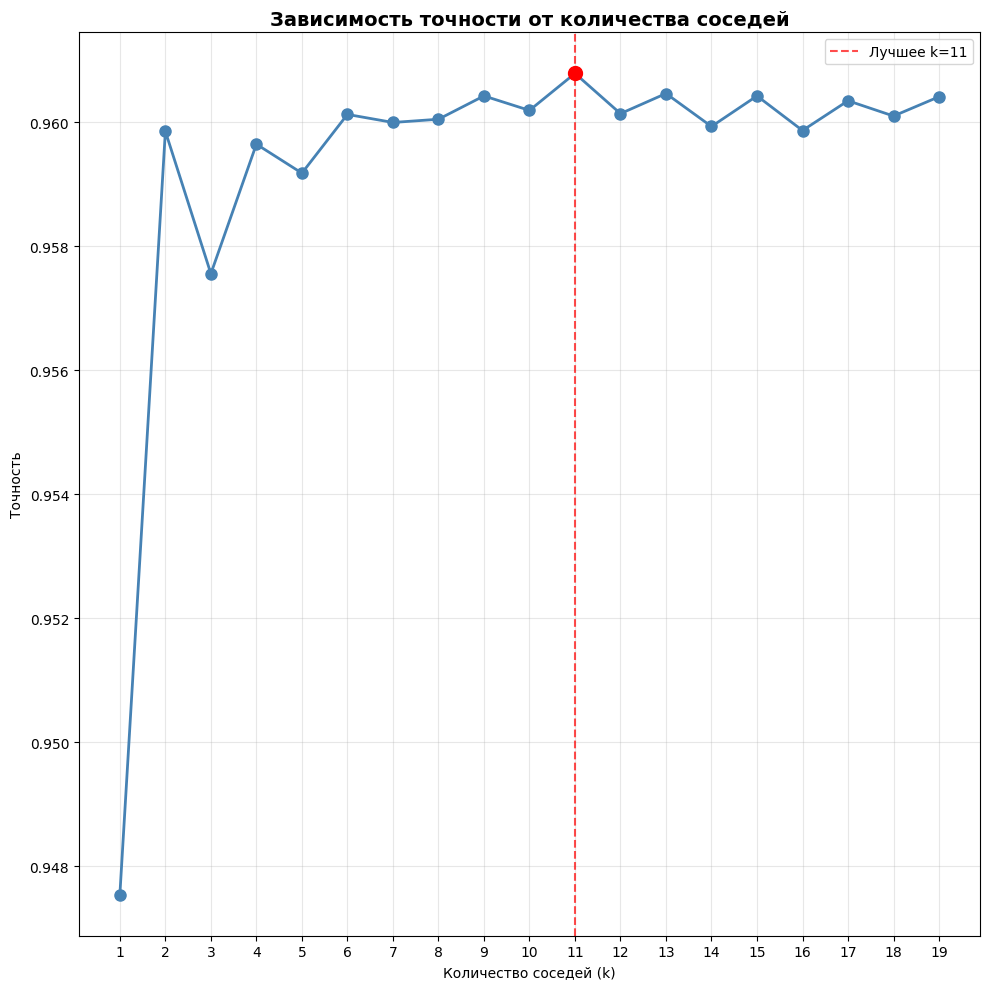

In [286]:
n = list(range(1, 20))

knn = KNeighborsClassifier()
grid = GridSearchCV(
    knn,
    param_grid={'n_neighbors': n},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_err = 1 - grid.best_score_
best_n = grid.best_estimator_.n_neighbors

print(f"ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:")
print(f"• Лучшее количество соседей (k): {best_n}")


results = grid.cv_results_
mean_scores = results['mean_test_score']
std_scores = results['std_test_score']

plt.figure(figsize=(10, 10))
plt.plot(n, mean_scores, marker='o', linewidth=2, markersize=8, color='steelblue')

plt.axvline(x=best_n, color='red', linestyle='--', alpha=0.7, label=f'Лучшее k={best_n}')
plt.scatter(best_n, grid.best_score_, color='red', s=100, zorder=5)

plt.title('Зависимость точности от количества соседей', fontweight='bold', fontsize=14)
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(n)
plt.tight_layout()
plt.show()

Получили оптимальное количество ближайших соседей равное 11. Точность модели превысила 96%

Проведем обучение финальной модели с оптимальным параметром:

In [287]:
knn_final = KNeighborsClassifier(n_neighbors=best_n)
knn_final.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

Проведем анализ ошибок:

In [288]:
err_train = 1 - knn_final.score(X_train, y_train)
err_test = 1 - knn_final.score(X_test, y_test)

print(f"\nОЦЕНКА ОШИБОК:")
print(f"• Ошибка на обучающей выборке: {err_train:.4f} ({err_train*100:.2f}%)")
print(f"• Ошибка на тестовой выборке:  {err_test:.4f} ({err_test*100:.2f}%)")

print(f"\nТОЧНОСТЬ МОДЕЛИ:")
print(f"• Accuracy на обучающей выборке: {knn_final.score(X_train, y_train):.4f} ({knn_final.score(X_train, y_train)*100:.2f}%)")
print(f"• Accuracy на тестовой выборке:  {knn_final.score(X_test, y_test):.4f} ({knn_final.score(X_test, y_test)*100:.2f}%)")


ОЦЕНКА ОШИБОК:
• Ошибка на обучающей выборке: 0.0364 (3.64%)
• Ошибка на тестовой выборке:  0.0398 (3.98%)

ТОЧНОСТЬ МОДЕЛИ:
• Accuracy на обучающей выборке: 0.9636 (96.36%)
• Accuracy на тестовой выборке:  0.9602 (96.02%)


Построение и анализ матрицы рассогласования:

Матрица рассогласования для тестовой выборки:


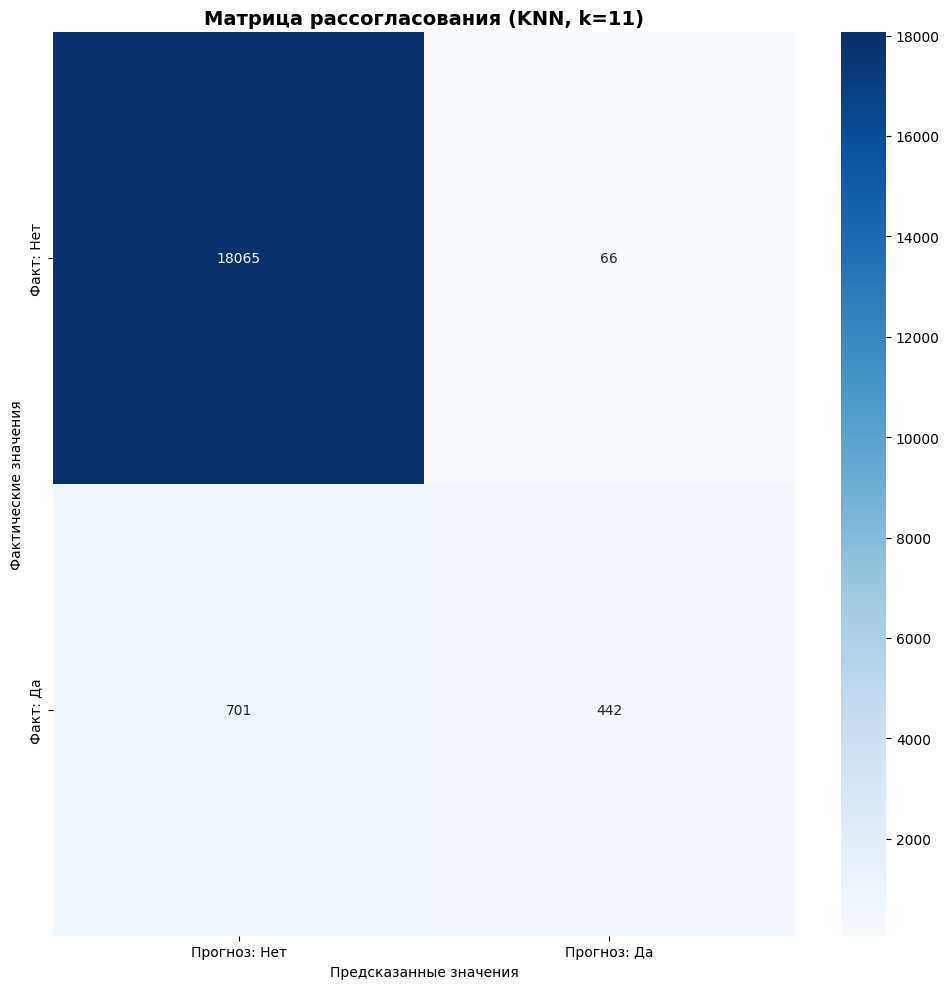

In [289]:
y_pred = knn_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Матрица рассогласования для тестовой выборки:")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Прогноз: Нет', 'Прогноз: Да'],
            yticklabels=['Факт: Нет', 'Факт: Да'])
plt.title(f'Матрица рассогласования (KNN, k={best_n})', fontweight='bold', fontsize=14)
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

Анализ матрицы рассогласования:

In [290]:
TN, FP, FN, TP = cm.ravel()

print(f"• True Negative (TN):  {TN:>6} - правильно предсказано отсутствие диабета")
print(f"• False Positive (FP): {FP:>6} - ложно предсказан диабет (ошибка I рода)")
print(f"• False Negative (FN): {FN:>6} - пропущен диабет (ошибка II рода)")
print(f"• True Positive (TP):  {TP:>6} - правильно предсказан диабет")

• True Negative (TN):   18065 - правильно предсказано отсутствие диабета
• False Positive (FP):     66 - ложно предсказан диабет (ошибка I рода)
• False Negative (FN):    701 - пропущен диабет (ошибка II рода)
• True Positive (TP):     442 - правильно предсказан диабет


Можно заметить большое количество ошибок II рода. Причиной тому может являться несбалансированность классов. Количество пациентов с диабетом в датасете намного меньше количества пациентов без диабета.

Попробуем решить проблему несбалансированности при помощи SMOTE

In [294]:
smote = SMOTE()
X_res, y_res = smote.fit_resample(X_train, y_train)

knn_final = KNeighborsClassifier(n_neighbors=best_n)
knn_final.fit(X_res, y_res)

err_train = 1 - knn_final.score(X_res, y_res)
err_test = 1 - knn_final.score(X_test, y_test)

print(f"\nОЦЕНКА ОШИБОК:")
print(f"• Ошибка на обучающей выборке: {err_train:.4f} ({err_train*100:.2f}%)")
print(f"• Ошибка на тестовой выборке:  {err_test:.4f} ({err_test*100:.2f}%)")

print(f"\nТОЧНОСТЬ МОДЕЛИ:")
print(f"• Accuracy на обучающей выборке: {knn_final.score(X_res, y_res):.4f} ({knn_final.score(X_res, y_res)*100:.2f}%)")
print(f"• Accuracy на тестовой выборке:  {knn_final.score(X_test, y_test):.4f} ({knn_final.score(X_test, y_test)*100:.2f}%)")



ОЦЕНКА ОШИБОК:
• Ошибка на обучающей выборке: 0.0540 (5.40%)
• Ошибка на тестовой выборке:  0.1175 (11.75%)

ТОЧНОСТЬ МОДЕЛИ:
• Accuracy на обучающей выборке: 0.9460 (94.60%)
• Accuracy на тестовой выборке:  0.8825 (88.25%)


Использование SMOTE снизило точность модели до 88.25%

Построение и анализ матрицы рассогласования:

Матрица рассогласования для тестовой выборки:


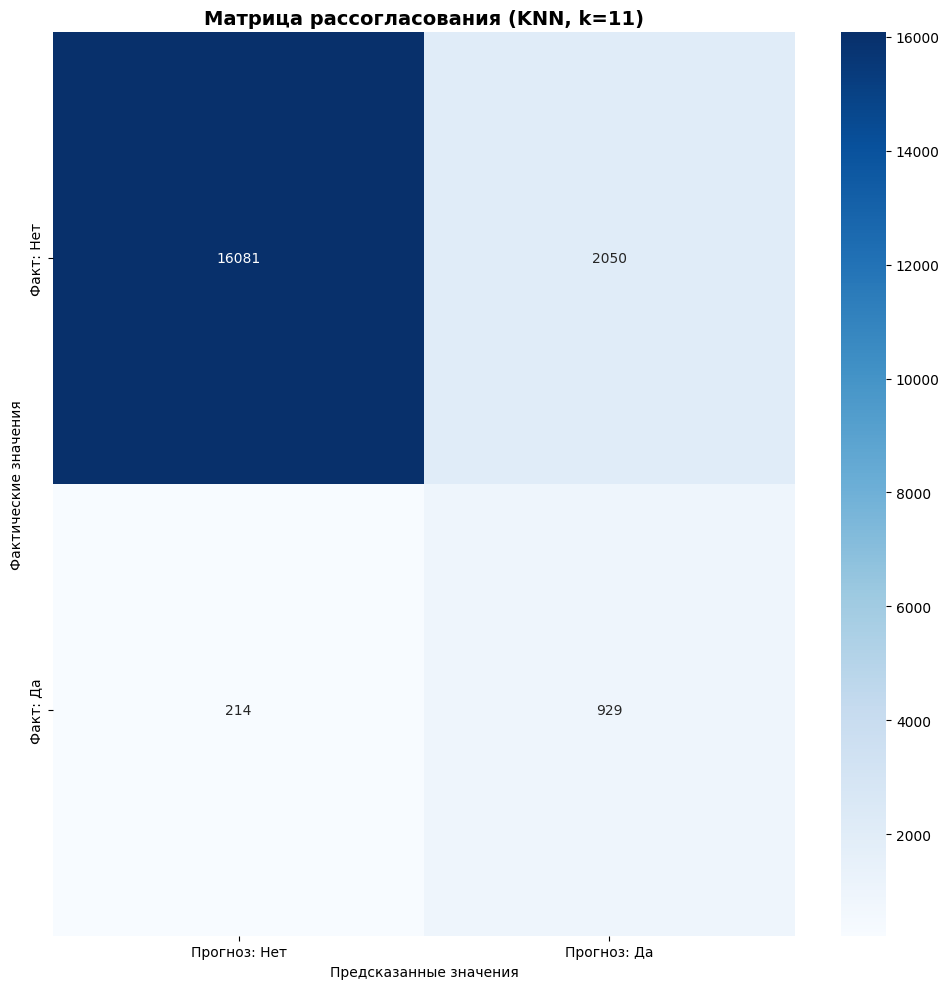

In [296]:
y_pred = knn_final.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Матрица рассогласования для тестовой выборки:")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Прогноз: Нет', 'Прогноз: Да'],
            yticklabels=['Факт: Нет', 'Факт: Да'])
plt.title(f'Матрица рассогласования (KNN, k={best_n})', fontweight='bold', fontsize=14)
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

Анализ матрицы рассогласования:

In [297]:
TN, FP, FN, TP = cm.ravel()

print(f"• True Negative (TN):  {TN:>6} - правильно предсказано отсутствие диабета")
print(f"• False Positive (FP): {FP:>6} - ложно предсказан диабет (ошибка I рода)")
print(f"• False Negative (FN): {FN:>6} - пропущен диабет (ошибка II рода)")
print(f"• True Positive (TP):  {TP:>6} - правильно предсказан диабет")

• True Negative (TN):   16081 - правильно предсказано отсутствие диабета
• False Positive (FP):   2050 - ложно предсказан диабет (ошибка I рода)
• False Negative (FN):    214 - пропущен диабет (ошибка II рода)
• True Positive (TP):     929 - правильно предсказан диабет


Использование SMOTE значительно снизило количество ошибок II рода, что в данной задаче наиболее важно, так как пропуск диабета наиболее опасен в реальных моделях.

В итоге процент верно предсказанного диабета составил 81.28% против 38.67% без использования SMOTE.

Попробуем улучшить качество предсказания при помощи использования случайного леса:

In [298]:
from sklearn import ensemble

rf_model = ensemble.RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

rf_train_predict = rf_model.predict(X_train)
rf_test_predict = rf_model.predict(X_test)

rf_train_error = 1 - accuracy_score(rf_train_predict, y_train)
rf_test_error  = 1 - accuracy_score(rf_test_predict, y_test)

print(f"\nОЦЕНКА ОШИБОК:")
print(f"• Ошибка на обучающей выборке: {rf_train_error:.4f} ({rf_train_error*100:.2f}%)")
print(f"• Ошибка на тестовой выборке:  {rf_test_error:.4f} ({rf_test_error*100:.2f}%)")

print(f"\nТОЧНОСТЬ МОДЕЛИ:")
print(f"• Accuracy на обучающей выборке: {rf_model.score(X_train, y_train):.4f} ({rf_model.score(X_train, y_train)*100:.2f}%)")
print(f"• Accuracy на тестовой выборке:  {rf_model.score(X_test, y_test):.4f} ({rf_model.score(X_test, y_test)*100:.2f}%)")


ОЦЕНКА ОШИБОК:
• Ошибка на обучающей выборке: 0.0008 (0.08%)
• Ошибка на тестовой выборке:  0.0320 (3.20%)

ТОЧНОСТЬ МОДЕЛИ:
• Accuracy на обучающей выборке: 0.9992 (99.92%)
• Accuracy на тестовой выборке:  0.9680 (96.80%)


Матрица рассогласования для тестовой выборки:


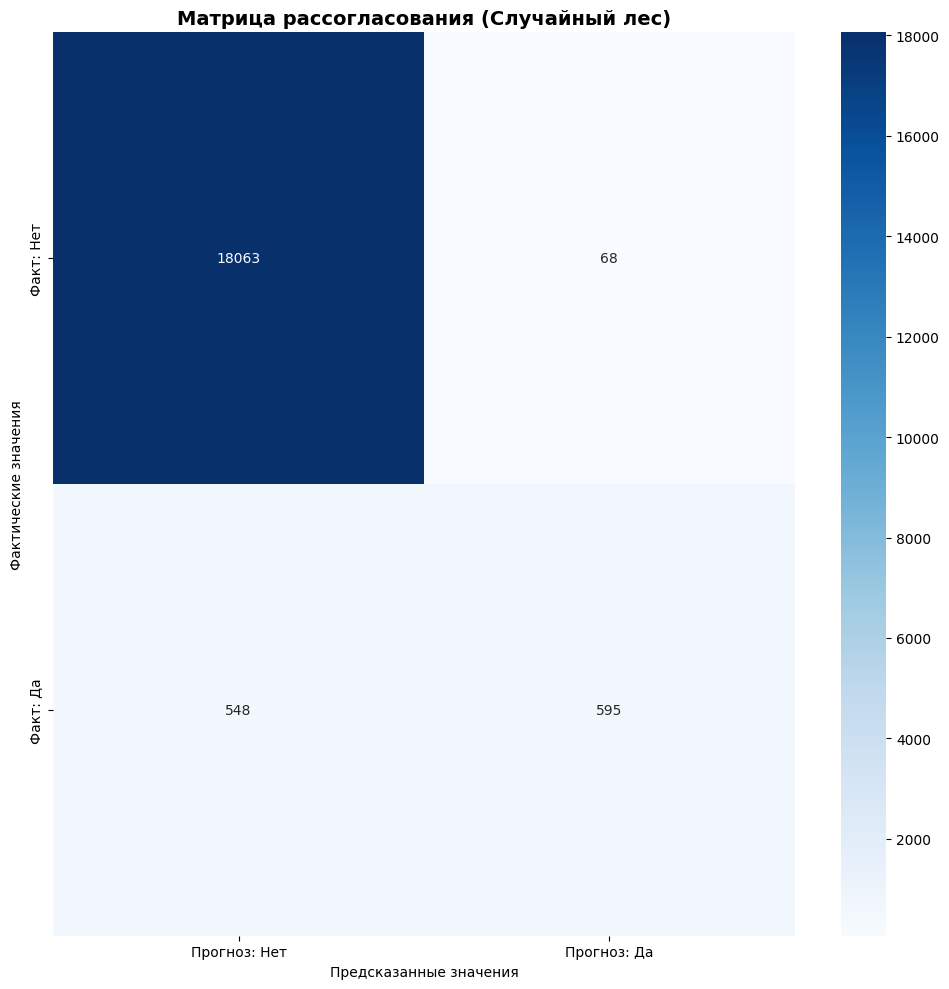

In [299]:
y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Матрица рассогласования для тестовой выборки:")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Прогноз: Нет', 'Прогноз: Да'],
            yticklabels=['Факт: Нет', 'Факт: Да'])
plt.title(f'Матрица рассогласования (Случайный лес)', fontweight='bold', fontsize=14)
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

Незначительно возросло количество ошибок I рода по отношению к KNN без сбалансированных данных, однако удалось существенно сократить число ошибок II рода, что в данной задаче более важно.

Попробуем улучшить результат, подобрав оптимальное количество деревьев:

In [300]:
N = list(range(100, 200, 10))

grid = GridSearchCV(
    rf_model,
    param_grid={'n_estimators': N},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)

best_err = 1 - grid.best_score_
best_est = grid.best_estimator_.n_estimators

print(f"ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:")
print(f"• Лучшее количество деревьев (k): {best_est}")

ОПТИМАЛЬНЫЕ ПАРАМЕТРЫ:
• Лучшее количество деревьев (k): 190


Построим матрицу рассогласования для n_estimates = 190:

In [313]:
rf_model = ensemble.RandomForestClassifier(n_estimators=best_est, random_state=42)
rf_model.fit(X_train, y_train)

rf_train_predict = rf_model.predict(X_train)
rf_test_predict = rf_model.predict(X_test)

rf_train_error = 1 - accuracy_score(rf_train_predict, y_train)
rf_test_error  = 1 - accuracy_score(rf_test_predict, y_test)

print(f"\nОЦЕНКА ОШИБОК:")
print(f"• Ошибка на обучающей выборке: {rf_train_error:.4f} ({rf_train_error*100:.2f}%)")
print(f"• Ошибка на тестовой выборке:  {rf_test_error:.4f} ({rf_test_error*100:.2f}%)")

print(f"\nТОЧНОСТЬ МОДЕЛИ:")
print(f"• Accuracy на обучающей выборке: {rf_model.score(X_train, y_train):.4f} ({rf_model.score(X_train, y_train)*100:.2f}%)")
print(f"• Accuracy на тестовой выборке:  {rf_model.score(X_test, y_test):.4f} ({rf_model.score(X_test, y_test)*100:.2f}%)")


ОЦЕНКА ОШИБОК:
• Ошибка на обучающей выборке: 0.0008 (0.08%)
• Ошибка на тестовой выборке:  0.0320 (3.20%)

ТОЧНОСТЬ МОДЕЛИ:
• Accuracy на обучающей выборке: 0.9992 (99.92%)
• Accuracy на тестовой выборке:  0.9680 (96.80%)


Матрица рассогласования для тестовой выборки:


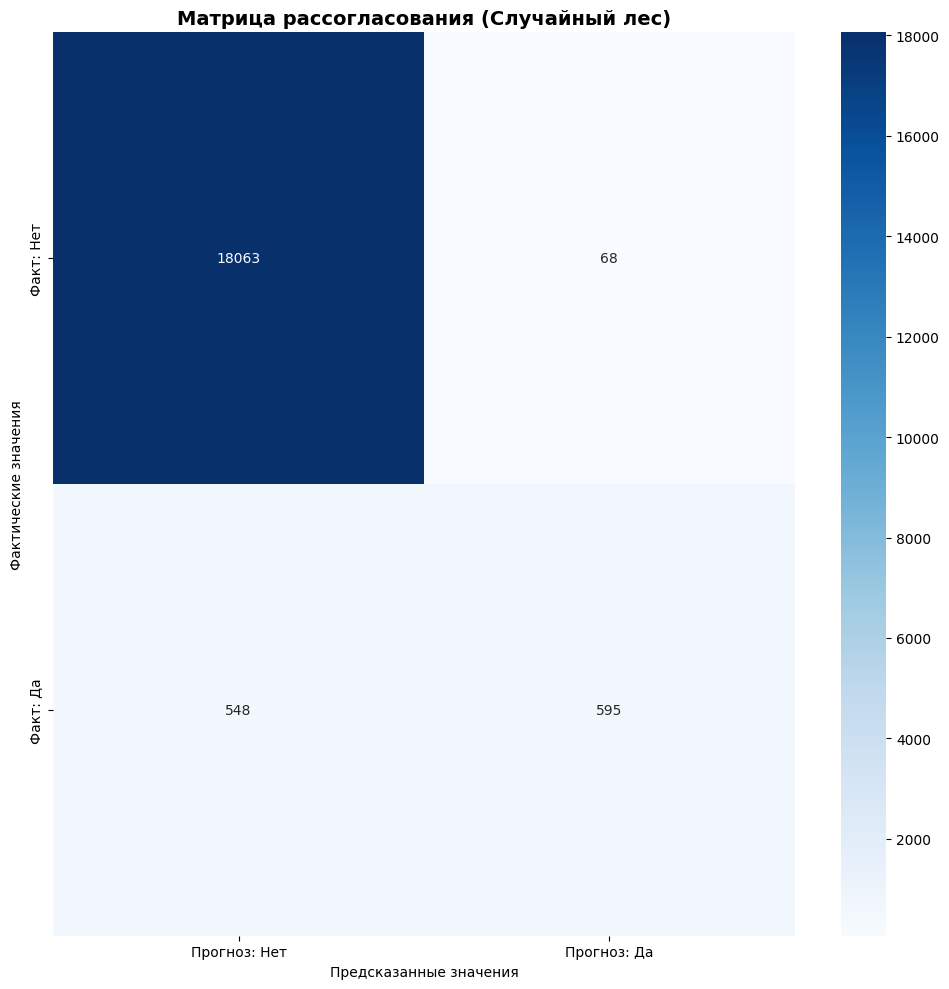

In [314]:
y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Матрица рассогласования для тестовой выборки:")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Прогноз: Нет', 'Прогноз: Да'],
            yticklabels=['Факт: Нет', 'Факт: Да'])
plt.title(f'Матрица рассогласования (Случайный лес)', fontweight='bold', fontsize=14)
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

Попробуем использовать SMOTE для улучшения качества модели:

In [315]:
rf_model = ensemble.RandomForestClassifier(n_estimators=best_est, random_state=42)
rf_model.fit(X_res, y_res)

rf_train_predict = rf_model.predict(X_res)
rf_test_predict = rf_model.predict(X_test)

rf_train_error = 1 - accuracy_score(rf_train_predict, y_res)
rf_test_error  = 1 - accuracy_score(rf_test_predict, y_test)

print(f"\nОЦЕНКА ОШИБОК:")
print(f"• Ошибка на обучающей выборке: {rf_train_error:.4f} ({rf_train_error*100:.2f}%)")
print(f"• Ошибка на тестовой выборке:  {rf_test_error:.4f} ({rf_test_error*100:.2f}%)")

print(f"\nТОЧНОСТЬ МОДЕЛИ:")
print(f"• Accuracy на обучающей выборке: {rf_model.score(X_train, y_train):.4f} ({rf_model.score(X_train, y_train)*100:.2f}%)")
print(f"• Accuracy на тестовой выборке:  {rf_model.score(X_test, y_test):.4f} ({rf_model.score(X_test, y_test)*100:.2f}%)")


ОЦЕНКА ОШИБОК:
• Ошибка на обучающей выборке: 0.0004 (0.04%)
• Ошибка на тестовой выборке:  0.0471 (4.71%)

ТОЧНОСТЬ МОДЕЛИ:
• Accuracy на обучающей выборке: 0.9992 (99.92%)
• Accuracy на тестовой выборке:  0.9529 (95.29%)


Матрица рассогласования для тестовой выборки:


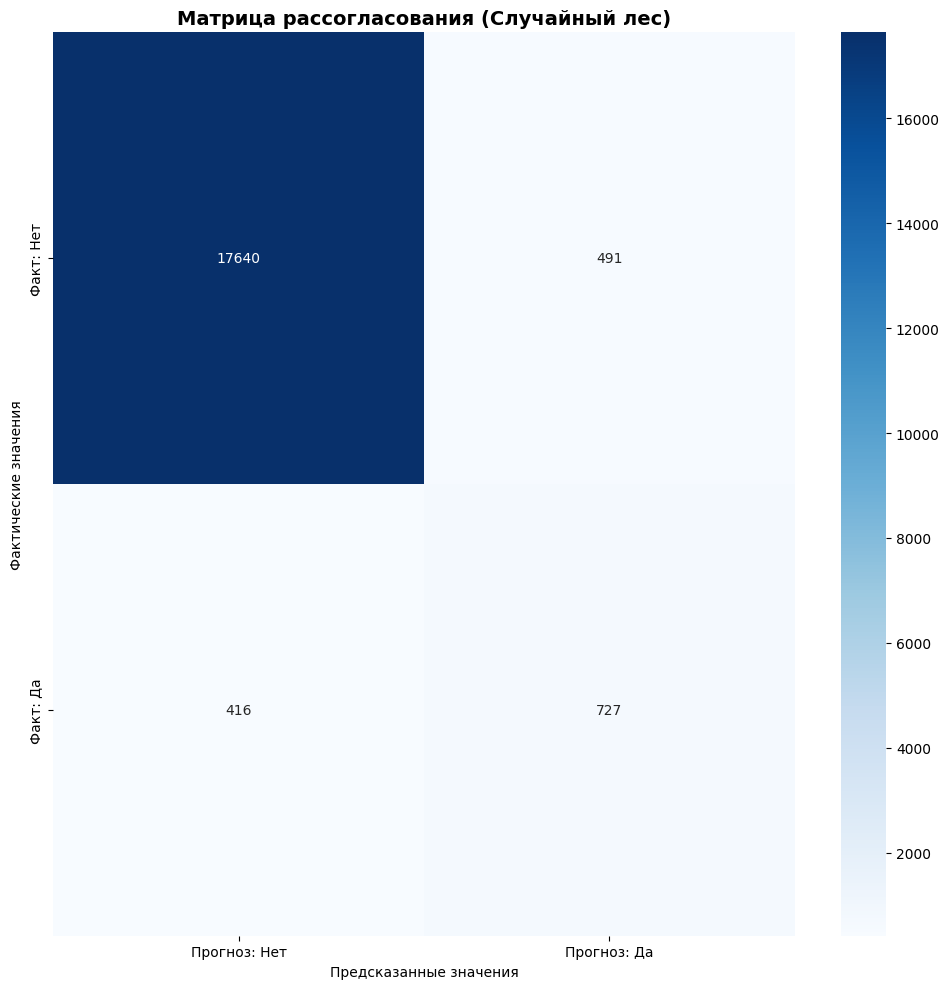

In [316]:
y_pred = rf_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Матрица рассогласования для тестовой выборки:")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Прогноз: Нет', 'Прогноз: Да'],
            yticklabels=['Факт: Нет', 'Факт: Да'])
plt.title(f'Матрица рассогласования (Случайный лес)', fontweight='bold', fontsize=14)
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

Несмотря на более высокую обзую точность модели, количество ошибок II рода случайный лес выдает больше.

Посторим также модель логистической регрессии:

In [320]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

log_reg_train_predict = log_reg.predict(X_train)
log_reg_test_predict = log_reg.predict(X_test)

log_reg_train_error = 1 - accuracy_score(log_reg_train_predict, y_train)
log_reg_test_error  = 1 - accuracy_score(log_reg_test_predict, y_test)

print(f"\nОЦЕНКА ОШИБОК:")
print(f"• Ошибка на обучающей выборке: {log_reg_train_error:.4f} ({log_reg_train_error*100:.2f}%)")
print(f"• Ошибка на тестовой выборке:  {log_reg_test_error:.4f} ({log_reg_test_error*100:.2f}%)")

print(f"\nТОЧНОСТЬ МОДЕЛИ:")
print(f"• Accuracy на обучающей выборке: {log_reg.score(X_train, y_train):.4f} ({log_reg.score(X_train, y_train)*100:.2f}%)")
print(f"• Accuracy на тестовой выборке:  {log_reg.score(X_test, y_test):.4f} ({log_reg.score(X_test, y_test)*100:.2f}%)")


ОЦЕНКА ОШИБОК:
• Ошибка на обучающей выборке: 0.0379 (3.79%)
• Ошибка на тестовой выборке:  0.0381 (3.81%)

ТОЧНОСТЬ МОДЕЛИ:
• Accuracy на обучающей выборке: 0.9621 (96.21%)
• Accuracy на тестовой выборке:  0.9619 (96.19%)


Матрица рассогласования для тестовой выборки:


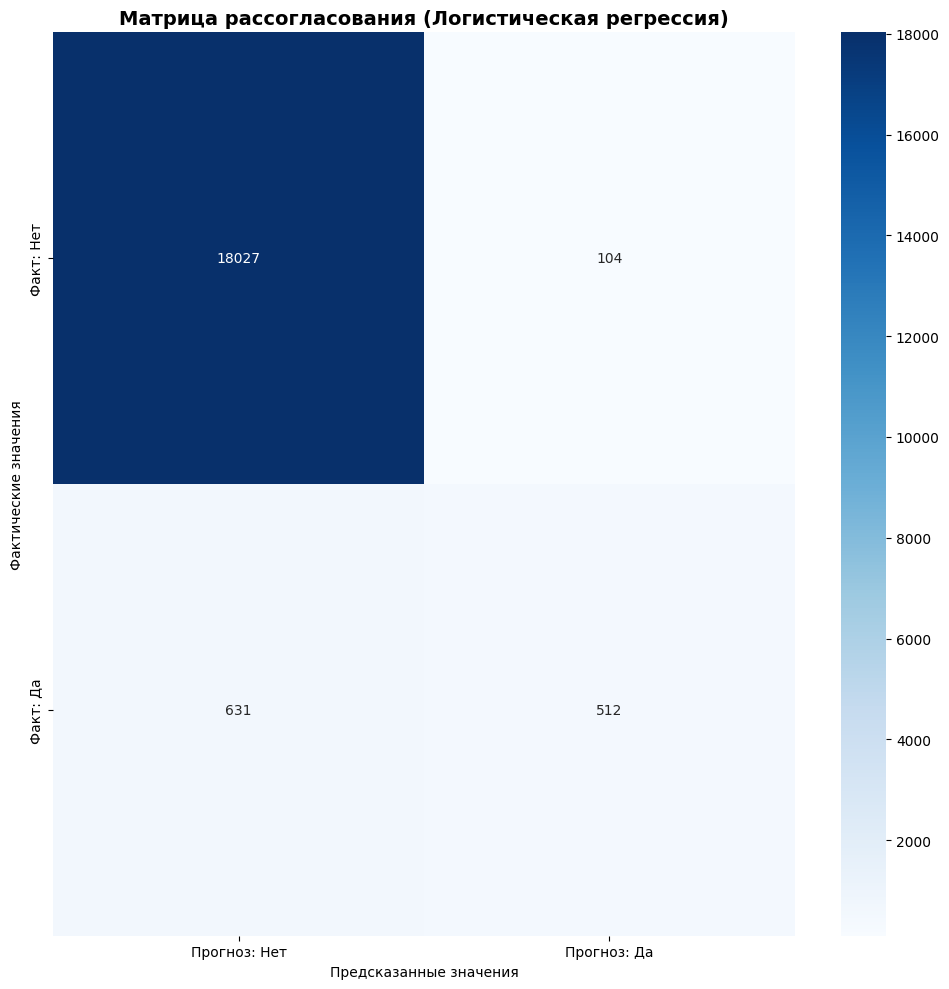

In [321]:
y_pred = log_reg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Матрица рассогласования для тестовой выборки:")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Прогноз: Нет', 'Прогноз: Да'],
            yticklabels=['Факт: Нет', 'Факт: Да'])
plt.title(f'Матрица рассогласования (Логистическая регрессия)', fontweight='bold', fontsize=14)
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

Результаты без балансировки самые лучшие: число ошибок II рода минимальное.

Используем SMOTE для борьбы с несбалансированностью:

In [322]:
log_reg = LogisticRegression()
log_reg.fit(X_res, y_res)

log_reg_train_predict = log_reg.predict(X_train)
log_reg_test_predict = log_reg.predict(X_test)

log_reg_train_error = 1 - accuracy_score(log_reg_train_predict, y_train)
log_reg_test_error  = 1 - accuracy_score(log_reg_test_predict, y_test)

print(f"\nОЦЕНКА ОШИБОК:")
print(f"• Ошибка на обучающей выборке: {log_reg_train_error:.4f} ({log_reg_train_error*100:.2f}%)")
print(f"• Ошибка на тестовой выборке:  {log_reg_test_error:.4f} ({log_reg_test_error*100:.2f}%)")

print(f"\nТОЧНОСТЬ МОДЕЛИ:")
print(f"• Accuracy на обучающей выборке: {log_reg.score(X_train, y_train):.4f} ({log_reg.score(X_train, y_train)*100:.2f}%)")
print(f"• Accuracy на тестовой выборке:  {log_reg.score(X_test, y_test):.4f} ({log_reg.score(X_test, y_test)*100:.2f}%)")


ОЦЕНКА ОШИБОК:
• Ошибка на обучающей выборке: 0.1410 (14.10%)
• Ошибка на тестовой выборке:  0.1427 (14.27%)

ТОЧНОСТЬ МОДЕЛИ:
• Accuracy на обучающей выборке: 0.8590 (85.90%)
• Accuracy на тестовой выборке:  0.8573 (85.73%)


Матрица рассогласования для тестовой выборки:


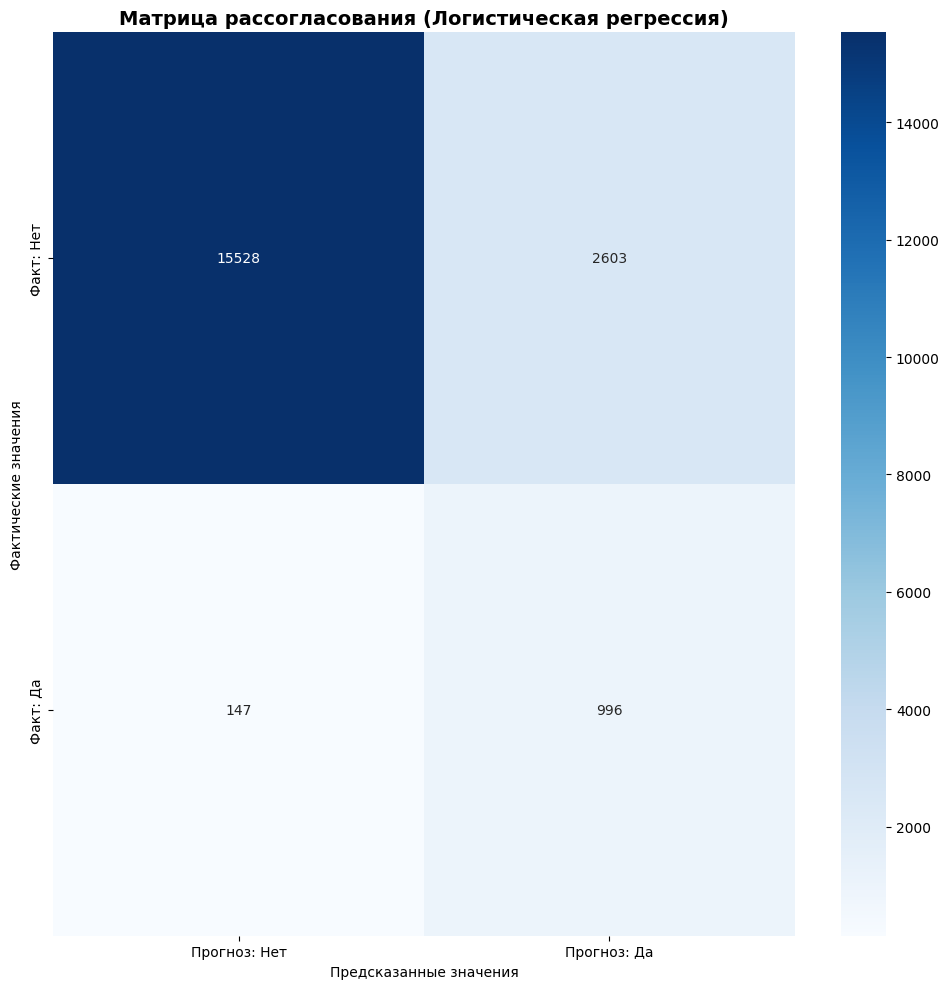

In [323]:
y_pred = log_reg.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

print("Матрица рассогласования для тестовой выборки:")
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Прогноз: Нет', 'Прогноз: Да'],
            yticklabels=['Факт: Нет', 'Факт: Да'])
plt.title(f'Матрица рассогласования (Логистическая регрессия)', fontweight='bold', fontsize=14)
plt.ylabel('Фактические значения')
plt.xlabel('Предсказанные значения')
plt.tight_layout()
plt.show()

Снизилась точность предсказания отсутствия диабета: возросло число ошибок I рода, однако число ошибок II рода достигло минимума.

In [324]:
TN, FP, FN, TP = cm.ravel()

print(f"• True Negative (TN):  {TN:>6} - правильно предсказано отсутствие диабета")
print(f"• False Positive (FP): {FP:>6} - ложно предсказан диабет (ошибка I рода)")
print(f"• False Negative (FN): {FN:>6} - пропущен диабет (ошибка II рода)")
print(f"• True Positive (TP):  {TP:>6} - правильно предсказан диабет")

• True Negative (TN):   15528 - правильно предсказано отсутствие диабета
• False Positive (FP):   2603 - ложно предсказан диабет (ошибка I рода)
• False Negative (FN):    147 - пропущен диабет (ошибка II рода)
• True Positive (TP):     996 - правильно предсказан диабет


**Выводы**

Для решения задачи бинарной классификации - предсказания диабета у пациентов были
применены три метода машинного обучения: метод ближайших соседей, случайный лес, и логистическая регрессия.

Наилучшим образом себя показали методы ближайших соседей для k = 11 и логистической регрессии. Метод ближайших соседей немного хуже предсказывает наличие диабета, однако лучше предсказывает его отсутствие, нежели логистическая регрессия и имеет более естественное обоснование его использования, так как в медицине используется аналогичный подход.

Случайный лес намного хуже предсказывает диабет, однако сильно лучше предсказывает его отсутствие. Но так как ошибки II рода более опасны, данный метод хуже подходит для данной задачи.

